<h1> Homework Set 6</h1>
Matt Buchovecky  
Astro 283 / Fitz 

In [1]:
import numpy as np
from scipy import optimize, special 
from matplotlib import pyplot as plt
from astropy.io import fits
%matplotlib inline

<h2> Problem 1

In [2]:
infile = open("./samplevals_PA.txt", 'r')
v_arr = [ ]

for line in iter(infile):
    line = line.split()
    try:
        float(line[0])
        v_arr.append(float(line[0]))
    except ValueError:
        continue
    
infile.close()


In [3]:
print(v_arr)

[3.268234568833195, 4.559128104426302, 9.952412352739938, 10.653534538036835, 5.838784012707487, 0.537382849676793, 7.700844168450949, 3.5868235601282272, 0.8893756846959922, 2.1763985114475304, 10.691842822083164, 8.391122773785431, 4.501693277379227, 2.622576726010284, 1.5392386446856254, 1.5437725138306102, 1.7699013063829039, 11.47863549609901, 5.125085938794893, 4.766521181897709, 0.9314251647394078, 6.176257938434682, 3.7687951140516374, 3.333455779322836, 4.433195145151503, 3.8722000665260325, 3.261930122936174, 7.579279779356263, 6.1002757807229635, 8.661302055006214, 11.053300867227067, 3.7037028069928812, 5.017700076928644, 8.181742162092064, 4.439296750219612, 3.6709851434633456, 9.373635083780874, 6.661202242753072, 18.255547975785536, 2.404939312768206, 4.613846612388805, 7.840872690360568, 1.467958348163112, 3.6470546198578258, 4.738737096390033, 6.022129175231994, 6.245327787763655, 7.194089565522965, 8.956268828916492, 8.431682218236459]


In [4]:
pyplot.hist(v_arr)

NameError: name 'pyplot' is not defined

In [ ]:
def Rice_dist(x, alpha, beta):
    """the pdf of the Rice distribution"""
    return (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha)

In [ ]:
def Rice_dist_n(x, alpha, beta):
    condlist = [ x>0 ]
    choicelist = [ (1/alpha)*np.exp((x+beta)/(-alpha))*special.iv(0, 2*np.sqrt(x*beta)/alpha) ]
    return np.select(condlist, choicelist, default=0.0)
        

In [ ]:
def neg_likelihood(params, value_array, function):
    """the opposite of the likelihood function for a set of independent values for a given \\
    function"""
    l = -1
    for x in value_array:
        l *= function(x, *params)
    return l


In [ ]:
# perform the optimization 
guess = (2, 3)
opt = optimize.fmin(neg_likelihood, guess, args=(v_arr, Rice_dist))
print(opt)

In [ ]:
# plot the Rice distribution with optimal values against normed histogram
r = np.arange(0., 20., 0.1)
plt.plot(r, Rice_dist(r, opt[0], opt[1]))
plt.hist(v_arr, normed=True)


In [ ]:
# define a mesh grid for parameter space plot 
alpha_range = np.linspace(1., 5., 100)
beta_range = np.linspace(1., 10., 100)
alpha_arr, beta_arr = np.meshgrid(alpha_range, beta_range)
#alpha_rav = alpha_rav.ravel()
#beta_rav = beta_rav.ravel()


In [ ]:
# positive likelihood values for Rice distribution! 
Rice_arr = -neg_likelihood((alpha_arr, beta_arr), v_arr, Rice_dist_n)


In [ ]:
pyplot.imshow(Rice_arr)


<h2> Problem 2 </h2>

In [ ]:
model_fits = fits.open("hw6prob2_model.fits")
psf_fits = fits.open("hw6prob2_psf.fits")
print(model_fits.info())
print(psf_fits.info())

model_data = model_fits[0].data
psf_data = psf_fits[0].data

model_fits.close()
psf_fits.close()


In [ ]:
plt.imshow(psf_data)
plt.colorbar()

In [ ]:
for s in (0, 31, 47, 63, 70, 95, 127):
    plt.figure()
    plt.imshow(model_data[:][s][:])
    pyplot.colorbar()

In [ ]:
import mpl_toolkits


In [ ]:
mpl_toolkits.mplot3d.Axes3D.contour(model_data)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
Axes3D.contour3D(model_data)

In [7]:

def cool_turkey_fft(arr, N, s, inverse=False, recursCall=False):
    
    s = int(s)
    if inverse:
        sign = -1
    else:
        sign = 1
    ARR = np.zeros(N, dtype=complex)
    if N == 1:
        ARR[0] = arr[0]
    else:
        #ARR[0:int(N/2)] = cool_turkey_fft(arr[0::2])
        #ARR[int(N/2)] = cool_turkey_fft(arr[1::2])
        N2 = int(N/2)
        ARR[0:N2] = cool_turkey_fft(arr[0::2*s], N2, s, inverse, recursCall=False)
        ARR[N2:] = cool_turkey_fft(arr[1::2*s], N2, s, inverse, recursCall=False)
        #ARReven = cool_turkey_fft(arr[0::2*s], N/2, s)
        #ARRodd = cool_turkey_fft(arr[s::2*s], N/2, s)
        for k in range(0, N2):
            orig = ARR[k]
            ARR[k] = orig + np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
            ARR[k+N2] = orig - np.exp(-sign*2*np.pi*(1j)*k/N)*ARR[k+N2]
    return ARR
    

In [9]:
x = np.linspace(0, 2*np.pi, 128, dtype=complex)
sinar = np.sin(3*x)


In [10]:
sinar_ctfft = cool_turkey_fft(sinar, 128, 1)
sinar_fft_np = np.fft.fft(sinar)


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


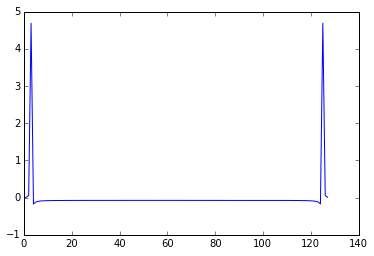

In [12]:
plt.plot(sinar_ctfft)

In [ ]:
print((1j)*(1j))
print(sinar)
print(sinar[1::2*1])
np.complex256